In [1]:
import hawkes_model as hx
import networkx as nx
import pickle
from copy import deepcopy
import numpy as np

# Generate Hawkes discussion tree

In the following example we generate the Hawkes discussion tree given the parameter values.

In [9]:
mu_params = (100, 500, 1.9)
phi_params = (4.2, 1.68, 0.6)
tree, success = hx.generation.hawkes_comment_tree(mu_params, phi_params, 7200, 1400)
timeseries = hx.get_timeseries_from_tree(tree)
print(success, nx.info(tree))
print("First 10 times:\n", timeseries[:10])

True Name: 
Type: Graph
Number of nodes: 190
Number of edges: 189
Average degree:   1.9895
First 10 times:
 [28.586294735903248, 66.29287177550744, 79.93189892318777, 123.28877922867711, 143.80314826298286, 156.70071211930377, 160.45240555216265, 162.87416824407532, 163.80320339982472, 179.060525792733]


# Continue generating a discussion tree using Hawkes process

In the following example, we first truncate the previously generated tree at `time = 500` and generate the rest of tree using the Hawkes discussion tree model with initial parameter values.

In [55]:
s_time = 500
trunc_tree = hx.truncate_tree_by_time(tree, s_time)
print("Size truncated tree:", len(trunc_tree))
print("   ------------- ")
gen_tree, success = hx.generation.continue_hawkes_comment_tree(trunc_tree, s_time, mu_params, phi_params, 
                                                     7200, 1400, limit_tree_size = 1000)
print("Size real tree:", len(tree))
print("Size generated tree:", len(gen_tree))

Size truncated tree: 79
   ------------- 
Size real tree: 190
Size generated tree: 150


# Generate other stuff

## Generate Poisson process with Weibull pdf intensity function

The arrival times of the Poisson process with Weibull intensity are modelled as follows. 

In [6]:
mu_params = (100, 500, 1.9)
weib_arrival_times = hx.generation.weibull_poisson_times(*mu_params)
print("Generated events:", len(weib_arrival_times))
print("First 10 times:\n", weib_arrival_times[:10])

Generated events: 82
First 10 times:
 [29.249554394061743, 60.2557371773945, 69.07501075283758, 69.49590635085256, 77.77082048172828, 111.50420601148907, 116.94862848815055, 130.87558013900724, 140.0345886110415, 161.65792873629644]


## Generate Poisson process with LogNormal pdf intensity function

The arrival times of the Poisson process with LogNormal intensity are modelled as follows. 

In [75]:
phi_params = (2.2, 1.68, 0.95)
lognorm_arrival_times = hx.generation.lognormal_poisson_times(*phi_params)
print("Generated events:", len(lognorm_arrival_times))
print("First 10 times:\n", lognorm_arrival_times[:10])

Generated events: 1
First 10 times:
 [3.35208873940046]


## Test how exposed portion of the original tree influences the quality of Hawkes prediction

In [79]:
mu_params = (100, 500, 1.9)
phi_params = (4.2, 1.68, 0.6)
tree, success = hx.generation.hawkes_comment_tree(mu_params, phi_params, 7200, 1400)
timeseries = hx.get_timeseries_from_tree(tree)
print("Tree size:", len(tree))
print("Last 10 times:\n", timeseries[-10:])

Tree size: 179
Last 10 times:
 [1162.6713569719627, 1259.521694069727, 1287.4089856137384, 1360.1280085541764, 1395.0759096928093, 1637.3136760729024, 1659.7026290031902, 1952.16393080832, 2289.3375416087338, 2294.928527801932]


In [82]:
from tqdm import tqdm

result_gen_sizes = []
for s_time in np.arange(200, 2000, 100):
    trunc_tree = hx.truncate_tree_by_time(tree, s_time)
    gen_sizes = []
    for i in tqdm(range(10000)):
        gen_tree, success = hx.generation.continue_hawkes_comment_tree(trunc_tree, s_time, mu_params, phi_params, 
                                                     7200, 1400, limit_tree_size = 1000)
        gen_sizes.append(len(gen_tree))
    result_gen_sizes.append((len(trunc_tree), np.mean(gen_sizes)))
print("DONE!")

100%|██████████| 10000/10000 [01:10<00:00, 142.03it/s]

DONE!


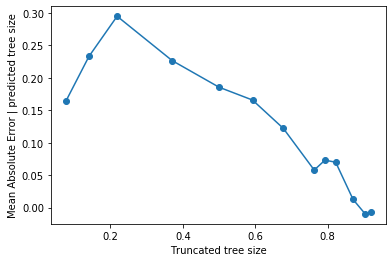

In [116]:
import matplotlib.pyplot as plt

X, Y = zip(*result_gen_sizes)
Y_percent = [(1-y/len(tree)) for y in Y]
X_percent = [x/len(tree) for x in X]
plt.plot(X_percent, Y_percent, marker = 'o')
# plt.plot([0,250], [len(tree),len(tree)], linewidth = 2, color = 'r')
plt.title("Prediction of tree size vs. exposed initial part of the tree")
plt.ylabel("Mean Absolute Error | predicted tree size")
plt.xlabel("Portion of the tree exposed")
plt.show()